In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!nvidia-smi

Tue Mar 14 05:36:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import gc
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import pdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.4f}'.format
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import pickle

import plotly.express as px
import plotly.graph_objects as go

In [4]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

In [5]:
def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * smap

In [6]:
BASE = '/kaggle/input/godaddy-microbusiness-density-forecasting/'
train = pd.read_csv(BASE + 'train.csv', encoding='utf-8')
test = pd.read_csv(BASE + 'test.csv', encoding='utf-8')
df_census = pd.read_csv(BASE + 'census_starter.csv', encoding='utf-8')
reaveal_test = pd.read_csv(BASE + 'revealed_test.csv', encoding='utf-8')
df_sub = pd.read_csv(BASE + 'sample_submission.csv', encoding='utf-8')
coords = pd.read_csv("/kaggle/input/usa-counties-coordinates/cfips_location.csv", encoding='utf-8')
os.environ["CUDA_VISIBLE_DEVICES"]="0"

drop_index = (test.first_day_of_month == '2022-11-01') | (test.first_day_of_month == '2022-12-01')
test = test.loc[~drop_index,:]

train = pd.concat([train,reaveal_test]).sort_values(by=['cfips','first_day_of_month']).reset_index()

train['istest'] = 0
test['istest'] = 1
raw = pd.concat((train, test)).sort_values(['cfips','row_id']).reset_index(drop=True)
raw = raw.merge(coords.drop("name", axis=1), on="cfips")


In [ ]:
reaveal_test.sort_values(by=['cfips','first_day_of_month'])

In [7]:
print(train.shape, test.shape, df_sub.shape)

(128535, 9) (18810, 4) (25080, 2)


In [8]:
# convert type
raw['state_i1'] = raw['state'].astype('category')
raw['county_i1'] = raw['county'].astype('category')
raw['first_day_of_month'] = pd.to_datetime(raw["first_day_of_month"])
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()
raw["dcount"] = raw.groupby(['cfips'])['row_id'].cumcount()
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
raw['state_i'] = raw['state'].factorize()[0]
raw['scale'] = (raw['first_day_of_month'] - raw['first_day_of_month'].min()).dt.days
raw['scale'] = raw['scale'].factorize()[0]
raw['year'] = raw['first_day_of_month'].dt.year
raw

,index,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,lng,lat,state_i1,county_i1,dcount,county_i,state_i,scale,year
0,0.0000,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.0077,1249.0000,0,-86.6429,32.5351,Alabama,Autauga County,0,0,0,0,2019
1,1.0000,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.8849,1198.0000,0,-86.6429,32.5351,Alabama,Autauga County,1,0,0,1,2019
2,2.0000,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.0558,1269.0000,0,-86.6429,32.5351,Alabama,Autauga County,2,0,0,2,2019
3,3.0000,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.9932,1243.0000,0,-86.6429,32.5351,Alabama,Autauga County,3,0,0,3,2019
4,4.0000,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.9932,1243.0000,0,-86.6429,32.5351,Alabama,Autauga County,4,0,0,4,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,NaN,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,-104.5674,43.8403,NaN,NaN,42,3134,50,42,2023
147341,NaN,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,-104.5674,43.8403,NaN,NaN,43,3134,50,43,2023
147342,NaN,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,-104.5674,43.8403,NaN,NaN,44,3134,50,44,2023
147343,NaN,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,-104.5674,43.8403,NaN,NaN,45,3134,50,45,2023


In [ ]:
test.first_day_of_month.unique()

In [6]:
raw.loc[raw.dcount==(40), :].reset_index(drop=True)

,index,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,lng,lat,state_i1,county_i1,dcount,county_i,state_i,scale,year
0,1.0000,1001_2022-12-01,1001,Autauga County,Alabama,2022-12-01,3.4709,1475.0000,0,-86.6429,32.5351,Alabama,Autauga County,40,0,0,40,2022
1,3.0000,1003_2022-12-01,1003,Baldwin County,Alabama,2022-12-01,8.2506,14133.0000,0,-87.7227,30.7278,Alabama,Baldwin County,40,1,0,40,2022
2,5.0000,1005_2022-12-01,1005,Barbour County,Alabama,2022-12-01,1.2523,248.0000,0,-85.3911,31.8701,Alabama,Barbour County,40,2,0,40,2022
3,7.0000,1007_2022-12-01,1007,Bibb County,Alabama,2022-12-01,1.2872,229.0000,0,-87.1268,32.9984,Alabama,Bibb County,40,3,0,40,2022
4,9.0000,1009_2022-12-01,1009,Blount County,Alabama,2022-12-01,1.8521,822.0000,0,-86.5670,33.9809,Alabama,Blount County,40,4,0,40,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,6261.0000,56037_2022-12-01,56037,Sweetwater County,Wyoming,2022-12-01,2.8768,922.0000,0,-108.8794,41.6598,Wyoming,Sweetwater County,40,3130,50,40,2022
3131,6263.0000,56039_2022-12-01,56039,Teton County,Wyoming,2022-12-01,26.3150,5043.0000,0,-110.5897,43.9346,Wyoming,Teton County,40,3131,50,40,2022
3132,6265.0000,56041_2022-12-01,56041,Uinta County,Wyoming,2022-12-01,4.0507,588.0000,0,-110.5474,41.2875,Wyoming,Uinta County,40,3132,50,40,2022
3133,6267.0000,56043_2022-12-01,56043,Washakie County,Wyoming,2022-12-01,3.0604,185.0000,0,-107.6823,43.9044,Wyoming,Washakie County,40,3133,50,40,2022


### There are some anomalies, specially at timestep 18

In [9]:
outliers = []
cnt = 0
for o in tqdm(raw.cfips.unique()):
    indices = (raw['cfips']==o)
    tmp = raw.loc[indices].copy().reset_index(drop=True)
    var = tmp.microbusiness_density.values.copy()
    #vmax = np.max(var[:38]) - np.min(var[:38])
    
    for i in range(40, 0, -1):
        thr = 0.20*np.mean(var[:i])
        difa = abs(var[i]-var[i-1])
        if (difa>=thr):
            var[:i] *= (var[i]/var[i-1])
            outliers.append(o)
            cnt+=1
    var[0] = var[1]*0.99
    raw.loc[indices, 'microbusiness_density'] = var
    
outliers = np.unique(outliers)
len(outliers), cnt

100%|██████████| 3135/3135 [00:05<00:00, 523.88it/s]


(552, 903)

In [ ]:
outliers

<AxesSubplot:xlabel='dcount'>

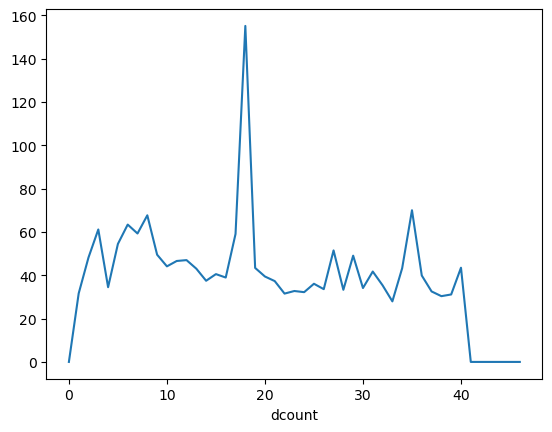

In [10]:
lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
raw['dif'] = raw['dif'].abs()
raw.groupby('dcount')['dif'].sum().plot()

### SMAPE is a relative metric so target must be converted.

In [11]:
raw['target'] = raw.groupby('cfips')['microbusiness_density'].shift(-1)
raw['target'] = raw['target']/raw['microbusiness_density'] - 1


raw.loc[raw['cfips']==28055, 'target'] = 0.0
raw.loc[raw['cfips']==48269, 'target'] = 0.0

raw.iloc[:20,:20]

,index,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,lng,lat,state_i1,county_i1,dcount,county_i,state_i,scale,year,mbd_lag_1,dif
0,0.0000,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,2.8560,1249.0000,0,-86.6429,32.5351,Alabama,Autauga County,0,0,0,0,2019,2.8560,0.0000
1,1.0000,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.8849,1198.0000,0,-86.6429,32.5351,Alabama,Autauga County,1,0,0,1,2019,2.8560,0.0101
2,2.0000,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.0558,1269.0000,0,-86.6429,32.5351,Alabama,Autauga County,2,0,0,2,2019,2.8849,0.0593
3,3.0000,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.9932,1243.0000,0,-86.6429,32.5351,Alabama,Autauga County,3,0,0,3,2019,3.0558,0.0205
4,4.0000,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.9932,1243.0000,0,-86.6429,32.5351,Alabama,Autauga County,4,0,0,4,2019,2.9932,0.0000
5,5.0000,1001_2020-01-01,1001,Autauga County,Alabama,2020-01-01,2.9691,1242.0000,0,-86.6429,32.5351,Alabama,Autauga County,5,0,0,5,2020,2.9932,0.0081
6,6.0000,1001_2020-02-01,1001,Autauga County,Alabama,2020-02-01,2.9093,1217.0000,0,-86.6429,32.5351,Alabama,Autauga County,6,0,0,6,2020,2.9691,0.0201
7,7.0000,1001_2020-03-01,1001,Autauga County,Alabama,2020-03-01,2.9332,1227.0000,0,-86.6429,32.5351,Alabama,Autauga County,7,0,0,7,2020,2.9093,0.0082
8,8.0000,1001_2020-04-01,1001,Autauga County,Alabama,2020-04-01,3.0002,1255.0000,0,-86.6429,32.5351,Alabama,Autauga County,8,0,0,8,2020,2.9332,0.0228
9,9.0000,1001_2020-05-01,1001,Autauga County,Alabama,2020-05-01,3.0049,1257.0000,0,-86.6429,32.5351,Alabama,Autauga County,9,0,0,9,2020,3.0002,0.0016


<AxesSubplot:>

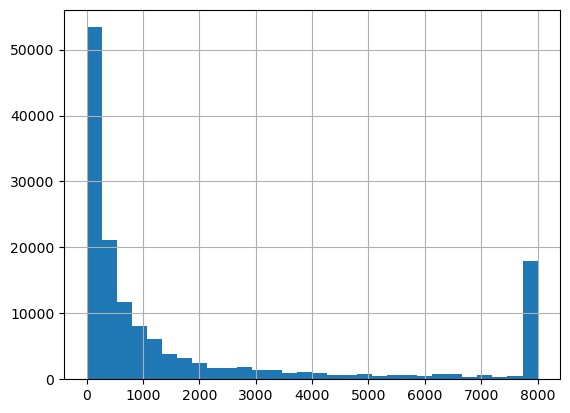

In [12]:
raw['lastactive'] = raw.groupby('cfips')['active'].transform('last')

dt = raw.loc[raw.dcount==40].groupby('cfips')['microbusiness_density'].agg('last')
raw['lasttarget'] = raw['cfips'].map(dt)

raw['lastactive'].clip(0, 8000).hist(bins=30)

### Feature Engineering

In [13]:
def build_features(raw, target='microbusiness_density', target_act='active_tmp', lags = 6):
    feats = []
    for lag in tqdm(range(1, lags)):
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target_act].diff(lag)
        feats.append(f'mbd_lag_{lag}')
        feats.append(f'act_lag_{lag}')
        
    lag = 1
    for window in [2, 4, 6, 8, 10]:
        raw[f'mbd_rollmea{window}_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(lambda s: s.rolling(window, min_periods=1).sum())        
        #raw[f'mbd_rollmea{window}_{lag}'] = raw[f'mbd_lag_{lag}'] - raw[f'mbd_rollmea{window}_{lag}']
        feats.append(f'mbd_rollmea{window}_{lag}')
      

    census_columns = list(df_census.columns)
    census_columns.remove( "cfips")
    
    raw = raw.merge(df_census, on="cfips", how="left")
    feats += census_columns
    
    co_est = pd.read_csv("/kaggle/input/us-indicator/co-est2021-alldata.csv", encoding='latin-1')
    co_est["cfips"] = co_est.STATE*1000 + co_est.COUNTY
    co_columns = [
        'SUMLEV',
        'DIVISION',
        'ESTIMATESBASE2020',
        'POPESTIMATE2020',
        'POPESTIMATE2021',
        'NPOPCHG2020',
        'NPOPCHG2021',
        'BIRTHS2020',
        'BIRTHS2021',
        'DEATHS2020',
        'DEATHS2021',
        'NATURALCHG2020',
        'NATURALCHG2021',
        'INTERNATIONALMIG2020',
        'INTERNATIONALMIG2021',
        'DOMESTICMIG2020',
        'DOMESTICMIG2021',
        'NETMIG2020',
        'NETMIG2021',
        'RESIDUAL2020',
        'RESIDUAL2021',
        'GQESTIMATESBASE2020',
        'GQESTIMATES2020',
        'GQESTIMATES2021',
        'RBIRTH2021',
        'RDEATH2021',
        'RNATURALCHG2021',
        'RINTERNATIONALMIG2021',
        'RDOMESTICMIG2021',
        'RNETMIG2021'
    ]
    
    raw = raw.merge(co_est, on="cfips", how="left")
    feats +=  co_columns
    
    return raw, feats

In [14]:
# Build Features based in lag of target
raw, feats = build_features(raw, 'target', 'active', lags = 9)
features = ['state_i']
features += feats
features += ['lng','lat']
features += ['scale']
print(features)
raw.loc[raw.dcount==40, features].head(10)

100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


['state_i', 'mbd_lag_1', 'act_lag_1', 'mbd_lag_2', 'act_lag_2', 'mbd_lag_3', 'act_lag_3', 'mbd_lag_4', 'act_lag_4', 'mbd_lag_5', 'act_lag_5', 'mbd_lag_6', 'act_lag_6', 'mbd_lag_7', 'act_lag_7', 'mbd_lag_8', 'act_lag_8', 'mbd_rollmea2_1', 'mbd_rollmea4_1', 'mbd_rollmea6_1', 'mbd_rollmea8_1', 'mbd_rollmea10_1', 'pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021', 'pct_college_2017', 'pct_college_2018', 'pct_college_2019', 'pct_college_2020', 'pct_college_2021', 'pct_foreign_born_2017', 'pct_foreign_born_2018', 'pct_foreign_born_2019', 'pct_foreign_born_2020', 'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018', 'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021', 'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019', 'median_hh_inc_2020', 'median_hh_inc_2021', 'SUMLEV', 'DIVISION', 'ESTIMATESBASE2020', 'POPESTIMATE2020', 'POPESTIMATE2021', 'NPOPCHG2020', 'NPOPCHG2021', 'BIRTHS2020', 'BIRTHS2021', 'DEATHS2020', 'DEATHS2021

,state_i,mbd_lag_1,act_lag_1,mbd_lag_2,act_lag_2,mbd_lag_3,act_lag_3,mbd_lag_4,act_lag_4,mbd_lag_5,...,GQESTIMATES2021,RBIRTH2021,RDEATH2021,RNATURALCHG2021,RINTERNATIONALMIG2021,RDOMESTICMIG2021,RNETMIG2021,lng,lat,scale
40,0,0.0082,12.0000,-0.0061,3.0000,0.0062,12.0000,0.0055,20.0000,-0.0041,...,442,11.0026,11.5451,-0.5425,0.0848,4.0179,4.1027,-86.6429,32.5351,40
87,0,-0.0008,-12.0000,-0.0122,-187.0000,0.0022,-156.0000,-0.0176,-412.0000,-0.0096,...,2177,9.5675,12.1371,-2.5697,0.2667,28.7024,28.9691,-87.7227,30.7278,40
134,0,0.0040,1.0000,0.0123,4.0000,0.0209,9.0000,0.0084,11.0000,-0.0166,...,2789,10.9285,15.7147,-4.7862,0.0399,-3.9087,-3.8689,-85.3911,31.8701,40
181,0,0.0088,2.0000,-0.0087,0.0000,-0.0214,-5.0000,0.0174,-1.0000,-0.0254,...,2062,10.1119,12.6174,-2.5056,0.0895,13.8255,13.9150,-87.1268,32.9984,40
228,0,0.0086,7.0000,0.0025,9.0000,-0.0109,0.0000,0.0086,7.0000,0.0025,...,449,10.6500,13.8840,-3.2339,0.0339,2.3704,2.4043,-86.5670,33.9809,40
275,0,0.0125,1.0000,0.0256,3.0000,0.0130,4.0000,0.0132,5.0000,0.0133,...,1725,12.6036,12.5067,0.0970,0.0970,0.6787,0.7756,-85.7157,32.1005,40
322,0,0.0060,2.0000,0.0000,2.0000,0.0090,5.0000,0.0279,14.0000,0.0319,...,241,11.2842,15.5554,-4.2711,0.1582,-4.3766,-4.2184,-86.6804,31.7525,40
369,0,0.0028,7.0000,-0.0060,-8.0000,-0.0032,-16.0000,0.0076,3.0000,0.0020,...,3251,11.3676,14.7435,-3.3758,0.0344,0.6028,0.6373,-85.8257,33.7714,40
416,0,0.0026,1.0000,0.0183,8.0000,-0.0402,-8.0000,-0.0124,-13.0000,-0.0171,...,449,10.2862,14.7936,-4.5074,0.6068,-0.2312,0.3756,-85.3917,32.9137,40
463,0,0.0084,2.0000,0.0170,6.0000,-0.0126,3.0000,0.0000,3.0000,-0.0083,...,181,9.5288,18.9374,-9.4087,0.0400,10.8500,10.8900,-85.6039,34.1759,40


Latitude and Longitude feature engineering from samu2505.

In [14]:
coordinates = raw[['lng', 'lat']].values

# Encoding tricks
emb_size = 20
precision = 1e6

latlon = np.expand_dims(coordinates, axis=-1)

m = np.exp(np.log(precision)/emb_size)
angle_freq = m ** np.arange(emb_size)
angle_freq = angle_freq.reshape(1,1, emb_size)
latlon = latlon * angle_freq
latlon[..., 0::2] = np.cos(latlon[..., 0::2])

In [15]:
def rot(df):
    for angle in [15, 30, 45]:
        df[f'rot_{angle}_x'] = (np.cos(np.radians(angle)) * df['lat']) + \
                                (np.sin(np.radians(angle)) * df['lng'])
        
        df[f'rot_{angle}_y'] = (np.cos(np.radians(angle)) * df['lat']) - \
                                (np.sin(np.radians(angle)) * df['lng'])
        
    return df

raw = rot(raw)

In [16]:
features += ['rot_15_x', 'rot_15_y', 'rot_30_x', 'rot_30_y', 'rot_45_x', 'rot_45_y']

In [ ]:
raw

In [17]:
for idx in raw.year.unique():
    if idx == 2019:
        raw.loc[raw.year == idx, f'pct_it_workers_{idx}'] = np.nan
        raw.loc[raw.year == idx, f'pct_it_workers_{idx+1}'] = np.nan
        raw.loc[raw.year == idx, f'pct_it_workers_{idx+2}'] = np.nan
        raw.loc[raw.year == idx, f'median_hh_inc_{idx}'] = np.nan
        raw.loc[raw.year == idx, f'median_hh_inc_{idx+1}'] = np.nan
        raw.loc[raw.year == idx, f'median_hh_inc_{idx+2}'] = np.nan
        raw.loc[raw.year == idx, f'pct_bb_{idx}'] = np.nan
        raw.loc[raw.year == idx, f'pct_bb_{idx+1}'] = np.nan
        raw.loc[raw.year == idx, f'pct_bb_{idx+2}'] = np.nan
        raw.loc[raw.year == idx, f'pct_college_{idx}'] = np.nan
        raw.loc[raw.year == idx, f'pct_college_{idx+1}'] = np.nan
        raw.loc[raw.year == idx, f'pct_college_{idx+2}'] = np.nan
        raw.loc[raw.year == idx, f'pct_foreign_born_{idx}'] = np.nan
        raw.loc[raw.year == idx, f'pct_foreign_born_{idx+1}'] = np.nan
        raw.loc[raw.year == idx, f'pct_foreign_born_{idx+2}'] = np.nan
        raw.loc[raw.year == idx, f'ESTIMATESBASE2020'] = np.nan
        raw.loc[raw.year == idx, f'POPESTIMATE2020'] = np.nan
        raw.loc[raw.year == idx, f'POPESTIMATE2021'] = np.nan
        raw.loc[raw.year == idx, f'NPOPCHG2020'] = np.nan
        raw.loc[raw.year == idx, f'NPOPCHG2021'] = np.nan
        raw.loc[raw.year == idx, f'BIRTHS2020'] = np.nan
        raw.loc[raw.year == idx, f'BIRTHS2021'] = np.nan
        raw.loc[raw.year == idx, f'DEATHS2020'] = np.nan
        raw.loc[raw.year == idx, f'DEATHS2021'] = np.nan
        raw.loc[raw.year == idx, f'NATURALCHG2020'] = np.nan
        raw.loc[raw.year == idx, f'NATURALCHG2021'] = np.nan
        raw.loc[raw.year == idx, f'INTERNATIONALMIG2020'] = np.nan
        raw.loc[raw.year == idx, f'INTERNATIONALMIG2021'] = np.nan
        raw.loc[raw.year == idx, f'DOMESTICMIG2020'] = np.nan
        raw.loc[raw.year == idx, f'DOMESTICMIG2021'] = np.nan
        raw.loc[raw.year == idx, f'NETMIG2020'] = np.nan
        raw.loc[raw.year == idx, f'NETMIG2021'] = np.nan
        raw.loc[raw.year == idx, f'RESIDUAL2020'] = np.nan
        raw.loc[raw.year == idx, f'RESIDUAL2021'] = np.nan
        raw.loc[raw.year == idx, f'GQESTIMATESBASE2020'] = np.nan
        raw.loc[raw.year == idx, f'GQESTIMATES2020'] = np.nan
        raw.loc[raw.year == idx, f'GQESTIMATES2021'] = np.nan
        raw.loc[raw.year == idx, f'RBIRTH2021'] = np.nan
        raw.loc[raw.year == idx, f'RDEATH2021'] = np.nan
        raw.loc[raw.year == idx, f'RNATURALCHG2021'] = np.nan
        raw.loc[raw.year == idx, f'RINTERNATIONALMIG2021'] = np.nan
        raw.loc[raw.year == idx, f'RDOMESTICMIG2021'] = np.nan
        raw.loc[raw.year == idx, f'RNETMIG2021'] = np.nan
    if idx == 2020:
        raw.loc[raw.year == idx, f'pct_it_workers_{idx}'] = np.nan
        raw.loc[raw.year == idx, f'pct_it_workers_{idx+1}'] = np.nan
        raw.loc[raw.year == idx, f'median_hh_inc_{idx}'] = np.nan
        raw.loc[raw.year == idx, f'median_hh_inc_{idx+1}'] = np.nan
        raw.loc[raw.year == idx, f'pct_bb_{idx}'] = np.nan
        raw.loc[raw.year == idx, f'pct_bb_{idx+1}'] = np.nan
        raw.loc[raw.year == idx, f'pct_college_{idx}'] = np.nan
        raw.loc[raw.year == idx, f'pct_college_{idx+1}'] = np.nan
        raw.loc[raw.year == idx, f'pct_foreign_born_{idx}'] = np.nan
        raw.loc[raw.year == idx, f'pct_foreign_born_{idx+1}'] = np.nan
        raw.loc[raw.year == idx, f'ESTIMATESBASE2020'] = np.nan
        raw.loc[raw.year == idx, f'POPESTIMATE2020'] = np.nan
        raw.loc[raw.year == idx, f'POPESTIMATE2021'] = np.nan
        raw.loc[raw.year == idx, f'NPOPCHG2020'] = np.nan
        raw.loc[raw.year == idx, f'NPOPCHG2021'] = np.nan
        raw.loc[raw.year == idx, f'BIRTHS2020'] = np.nan
        raw.loc[raw.year == idx, f'BIRTHS2021'] = np.nan
        raw.loc[raw.year == idx, f'DEATHS2020'] = np.nan
        raw.loc[raw.year == idx, f'DEATHS2021'] = np.nan
        raw.loc[raw.year == idx, f'NATURALCHG2020'] = np.nan
        raw.loc[raw.year == idx, f'NATURALCHG2021'] = np.nan
        raw.loc[raw.year == idx, f'INTERNATIONALMIG2020'] = np.nan
        raw.loc[raw.year == idx, f'INTERNATIONALMIG2021'] = np.nan
        raw.loc[raw.year == idx, f'DOMESTICMIG2020'] = np.nan
        raw.loc[raw.year == idx, f'DOMESTICMIG2021'] = np.nan
        raw.loc[raw.year == idx, f'NETMIG2020'] = np.nan
        raw.loc[raw.year == idx, f'NETMIG2021'] = np.nan
        raw.loc[raw.year == idx, f'RESIDUAL2020'] = np.nan
        raw.loc[raw.year == idx, f'RESIDUAL2021'] = np.nan
        raw.loc[raw.year == idx, f'GQESTIMATESBASE2020'] = np.nan
        raw.loc[raw.year == idx, f'GQESTIMATES2020'] = np.nan
        raw.loc[raw.year == idx, f'GQESTIMATES2021'] = np.nan
        raw.loc[raw.year == idx, f'RBIRTH2021'] = np.nan
        raw.loc[raw.year == idx, f'RDEATH2021'] = np.nan
        raw.loc[raw.year == idx, f'RNATURALCHG2021'] = np.nan
        raw.loc[raw.year == idx, f'RINTERNATIONALMIG2021'] = np.nan
        raw.loc[raw.year == idx, f'RDOMESTICMIG2021'] = np.nan
        raw.loc[raw.year == idx, f'RNETMIG2021'] = np.nan
    if idx == 2021:
        raw.loc[raw.year == idx, f'pct_it_workers_{idx}'] = np.nan
        raw.loc[raw.year == idx, f'median_hh_inc_{idx}'] = np.nan
        raw.loc[raw.year == idx, f'pct_bb_{idx}'] = np.nan
        raw.loc[raw.year == idx, f'pct_college_{idx}'] = np.nan
        raw.loc[raw.year == idx, f'pct_foreign_born_{idx}'] = np.nan
        raw.loc[raw.year == idx, f'POPESTIMATE2021'] = np.nan
        raw.loc[raw.year == idx, f'NPOPCHG2021'] = np.nan
        raw.loc[raw.year == idx, f'BIRTHS2021'] = np.nan
        raw.loc[raw.year == idx, f'DEATHS2021'] = np.nan
        raw.loc[raw.year == idx, f'NATURALCHG2021'] = np.nan
        raw.loc[raw.year == idx, f'INTERNATIONALMIG2021'] = np.nan
        raw.loc[raw.year == idx, f'DOMESTICMIG2021'] = np.nan
        raw.loc[raw.year == idx, f'NETMIG2021'] = np.nan
        raw.loc[raw.year == idx, f'RESIDUAL2021'] = np.nan
        raw.loc[raw.year == idx, f'GQESTIMATES2021'] = np.nan
        raw.loc[raw.year == idx, f'RBIRTH2021'] = np.nan
        raw.loc[raw.year == idx, f'RDEATH2021'] = np.nan
        raw.loc[raw.year == idx, f'RNATURALCHG2021'] = np.nan
        raw.loc[raw.year == idx, f'RINTERNATIONALMIG2021'] = np.nan
        raw.loc[raw.year == idx, f'RDOMESTICMIG2021'] = np.nan
        raw.loc[raw.year == idx, f'RNETMIG2021'] = np.nan

In [ ]:
raw.loc[raw.dcount==10, features].head(10)

### stacking

In [18]:
def get_model():
    from sklearn.ensemble import VotingRegressor
    import lightgbm as lgb
    import xgboost as xgb
    import catboost as cat
    from sklearn.pipeline import Pipeline
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.impute import KNNImputer    

# we should decrease the num_iterations of catboost
    cat_model = cat.CatBoostRegressor(
        iterations=2000,
        loss_function="MAPE",
        verbose=0,
        grow_policy='SymmetricTree',
        learning_rate=0.035,
        colsample_bylevel=0.8,
        max_depth=5,
        l2_leaf_reg=0.2,
        subsample=0.70,
        max_bin=4096,
    )

    return cat_model


def base_models():
    from sklearn.ensemble import VotingRegressor
    import lightgbm as lgb
    import xgboost as xgb
    import catboost as cat
    from sklearn.pipeline import Pipeline
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.impute import KNNImputer    
    
    # LGBM model
    params = {
    'n_iter': 300,
    'boosting_type': 'dart',
    'verbosity': -1,
    'objective': 'l1',
    'random_state': 42,
    'colsample_bytree': 0.8841279649367693,
    'colsample_bynode': 0.10142964450634374,
    'max_depth': 8,
    'learning_rate': 0.003647749926797374,
    'lambda_l2': 0.5,
    'num_leaves': 61,
    "seed": 42,
    'min_data_in_leaf': 213,
    'device':'gpu'}

    lgb_model = lgb.LGBMRegressor(**params)
    
    xgb_model = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    tree_method="gpu_hist",
    n_estimators=795,
    learning_rate=0.0075,
    max_leaves = 17,
    subsample=0.50,
    colsample_bytree=0.50,
    max_bin=4096,
    n_jobs=2)

    # we should decrease the num_iterations of catboost
    cat_model = cat.CatBoostRegressor(
        iterations=2000,
        loss_function="MAPE",
        verbose=0,
        grow_policy='SymmetricTree',
        learning_rate=0.035,
        colsample_bylevel=0.8,
        max_depth=5,
        l2_leaf_reg=0.2,
        subsample=0.70,
        max_bin=4096,
    )
#     cat_model = cat.CatBoostRegressor(
#         iterations=2000,
#         loss_function="MAPE",
#         verbose=0,
#         task_type='GPU',
#         bootstrap_type='Bayesian',
#         subsample=None,
#         sampling_frequency=int(len(raw)*0.7),
#         max_depth=5,
#         l2_leaf_reg=0.2,
#         colsample_bylevel=0.8,
#         max_bin=4096,
#     )
    
    models = {}
    models['xgb'] = xgb_model
    models['lgbm'] = lgb_model
    models['cat'] = cat_model

    return models

In [19]:
ACT_THR = 150
MONTH_1 = 39
MONTH_last = 41


In [20]:
raw['ypred_last'] = np.nan
raw['ypred'] = np.nan
raw['k'] = 1.
raw['microbusiness_density'].fillna(2, inplace = True)


for TS in range(MONTH_1, MONTH_last): #40):
    print(f'TS: {TS}')
   
    # model = get_model()
    models = base_models()
    model0 = models['xgb']
    model1 = models['lgbm']
    model2 = models['cat']
            
    train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR) 
    valid_indices = (raw.istest==0) & (raw.dcount == TS) 
    
    # Train each of the models on the current TS
    model0.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.002, 0.006))
    
    model1.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.002, 0.006))
    
    model2.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.002, 0.006))
    

    tr_pred0 = model0.predict(raw.loc[train_indices, features])
    tr_pred1 = model1.predict(raw.loc[train_indices, features])
    tr_pred2 = model2.predict(raw.loc[train_indices, features])
    train_preds = np.column_stack((tr_pred0, tr_pred1, tr_pred2))
    
    meta_model = get_model() 
    meta_model.fit(train_preds, raw.loc[train_indices, 'target'].clip(-0.002, 0.006))
    
    val_preds0 = model0.predict(raw.loc[valid_indices, features])
    val_preds1 = model1.predict(raw.loc[valid_indices, features])
    val_preds2 = model2.predict(raw.loc[valid_indices, features])
    valid_preds = np.column_stack((val_preds0, val_preds1, val_preds2))
    
    ypred = meta_model.predict(valid_preds)
    raw.loc[valid_indices, 'k'] = ypred + 1
    raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

    # Validate
    lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
    dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']
    
    df = raw.loc[raw.dcount==(TS+1), 
                 ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
    df['pred'] = df['cfips'].map(dt)
    df['lastval'] = df['cfips'].map(lastval)
    
#     df.loc[df['lastval'].isnull(), 'lastval'] = df.loc[df['lastval'].isnull(), 'microbusiness_density']    
    
    df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']
        
    raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
    raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values
    
    print('Last Value SMAPE:', smape(df['microbusiness_density'], df['lastval']) )
    print('SMAPE:', smape(df['microbusiness_density'], df['pred']))
    print()

ind = (raw.dcount > MONTH_1)&(raw.dcount <= MONTH_last)

print('SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred']))
print('Last Value SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred_last']))

TS: 39


[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Warning] num_iterations is set=300, n_iter=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] min_data_in_leaf is set=213, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=213
Last Value SMAPE: 1.434638432637739
SMAPE: 1.4090235764548662

TS: 40
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Warning] num_iterations is set=300, n_iter=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] min_data_in_leaf is set=213, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=213
Last Value SMAPE: 58.4887389092275
SMAPE: 58.60338016267641

SMAPE: 

### Voting

In [17]:
def get_model():
    from sklearn.ensemble import VotingRegressor
    import lightgbm as lgb
    import xgboost as xgb
    import catboost as cat
    from sklearn.pipeline import Pipeline
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.impute import KNNImputer
    
    params = {
    'n_iter': 200,
    'verbosity': -1,
    'objective': 'l1',
    'random_state': 42,
    'colsample_bytree': 0.8841279649367693,
    'colsample_bynode': 0.10142964450634374,
    'max_depth': 8,
    'learning_rate': 0.013647749926797374,
    'lambda_l1': 1.8386216853616875,
    'lambda_l2': 7.557660410418351,
    'num_leaves': 61,
    "seed": 42,
    'min_data_in_leaf': 213
    }

    lgb_model = lgb.LGBMRegressor(**params)
#     params = {
#         'objective': 'huber',
#         'metric': 'mae', 
#         "seed": 42,
#     }

#     lgb_model = lgb.LGBMRegressor(
#         n_estimators=1200,
#         learning_rate=0.075,
#         max_leaves = 31,
#         subsample=0.60,
#         colsample_bytree=0.50,
#         max_bin=4096,
#         l2=0.1,
#         **params
#     )
    
    xgb_model = xgb.XGBRegressor(
        objective='reg:pseudohubererror',
        #objective='reg:squarederror',
        tree_method="hist",
        n_estimators=795,
        learning_rate=0.0075,
        max_leaves = 17,
        subsample=0.50,
        colsample_bytree=0.50,
        max_bin=4096,
        n_jobs=2,
        
#         eval_metric='mae',
#         early_stopping_rounds=70,
    )
    
    cat_model = cat.CatBoostRegressor(
        iterations=2000,
        loss_function="MAPE",
        verbose=0,
        grow_policy='SymmetricTree',
#         objective="Huber",
        learning_rate=0.035,
        l2_leaf_reg=0.2,
        colsample_bylevel=0.8,
#         max_leaves = 17,
        subsample=0.70,
        max_bin=4096,
        max_depth=5,
#         delta=0.01
    )
    

    knn_model = Pipeline([
        ('imputer',  KNNImputer(n_neighbors=2)),
        ('knn', KNeighborsRegressor(5))
    ])
    
    return VotingRegressor([
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('cat', cat_model),
        ('knn', knn_model)
    ])

In [ ]:
blacklist = [
    'North Dakota', 'Iowa', 'Kansas', 'Nebraska', 'South Dakota','New Mexico', 'Alaska', 'Vermont'
]
blacklistcfips = [
1019,1027,1029,1035,1039,1045,1049,1057,1067,1071,1077,1085,1091,1099,1101,1123,1131,1133,4001,4012,4013,4021,4023,5001,5003,5005,5017,5019,5027,5031,5035,5047,5063,5065,5071,5081,5083,5087,5091,5093,5107,5109,5115,5121,5137,5139,5141,5147,6003,6015,6027,6033,6053,6055,6057,6071,6093,6097,6103,6105,6115,8003,8007,8009,8019,8021,8023,8047,8051,8053,8055,8057,8059,8061,8065,8067,8069,8071,8073,8075,8085,8091,8093,8097,8099,8103,8105,8107,8109,8111,8115,8117,8121,9007,9009,9015,12009,12017,12019,12029,12047,12055,12065,12075,12093,12107,12127,13005,13007,13015,13017,13019,13027,13035,13047,13065,13081,13083,13099,13107,13109,13117,13119,13121,13123,13125,13127,13135,13143,13147,13161,13165,13171,13175,13181,13193,13201,13221,13225,13229,13231,13233,13245,13247,13249,13257,13279,13281,13287,13289,13293,13301,13319,15001,15005,15007,16001,16003,16005,16007,16013,16015,16017,16023,16025,16029,16031,16033,16035,16037,16043,16045,16049,16061,16063,16067,17001,17003,17007,17009,17013,17015,17023,17025,17031,17035,17045,17051,17059,17061,17063,17065,17067,17069,17075,17077,17081,17085,17087,17103,17105,17107,17109,17115,17117,17123,17127,17133,17137,17141,17143,17147,17153,17167,17169,17171,17177,17179,17181,17185,17187,17193,18001,18007,18009,18013,18015,18019,18021,18025,18035,18037,18039,18041,18053,18061,18075,18079,18083,18087,18099,18103,18111,18113,18115,18137,18139,18145,18153,18171,18179,21001,21003,21013,21017,21023,21029,21035,21037,21039,21045,21047,21055,21059,21065,21075,21077,21085,21091,21093,21097,21099,21101,21103,21115,21125,21137,21139,21141,21149,21155,21157,21161,21165,21179,21183,21191,21197,21199,21215,21217,21223,21227,21237,21239,22019,22021,22031,22039,22041,22047,22069,22085,22089,22101,22103,22109,22111,22115,22119,22121,23003,23009,23021,23027,23029,24011,24027,24029,24031,24035,24037,24039,24041,25011,25015,26003,26007,26011,26019,26021,26025,26027,26033,26037,26041,26043,26051,26053,26057,26059,26061,26065,26071,26077,26079,26083,26089,26097,26101,26103,26109,26111,26115,26117,26119,26127,26129,26131,26135,26141,26143,26155,26161,26165,27005,27011,27013,27015,27017,27021,27023,27025,27029,27047,27051,27055,27057,27065,27069,27073,27075,27077,27079,27087,27091,27095,27101,27103,27105,27107,27109,27113,27117,27119,27123,27125,27129,27131,27133,27135,27141,27147,27149,27155,27159,27167,27169,28017,28019,28023,28025,28035,28045,28049,28061,28063,28093,28097,28099,28125,28137,28139,28147,28159,29001,29015,29019,29031,29033,29041,29049,29051,29055,29057,29063,29065,29069,29075,29085,29089,29101,29103,29111,29121,29123,29125,29135,29137,29139,29143,29157,29159,29161,29167,29171,29173,29175,29177,29183,29195,29197,29199,29203,29205,29207,29209,29213,29215,29217,29223,29227,29229,30005,30009,30025,30027,30033,30035,30037,30039,30045,30049,30051,30053,30055,30057,30059,30069,30071,30073,30077,30079,30083,30085,30089,30091,30093,30101,30103,30105,30107,30109,32005,32009,32017,32023,32027,32029,32510,33005,33007,34021,34027,34033,34035,36011,36017,36023,36033,36043,36047,36049,36051,36057,36061,36067,36083,36091,36097,36103,36107,36113,36115,36121,36123,37005,37009,37011,37017,37023,37029,37031,37049,37061,37075,37095,37117,37123,37131,37137,37151,37187,37189,37197,39005,39009,39015,39017,39019,39023,39037,39039,39043,39049,39053,39057,39063,39067,39071,39077,39085,39087,39091,39097,39105,39107,39113,39117,39119,39125,39127,39129,39135,39137,39151,39153,39157,40003,40013,40015,40023,40025,40027,40035,40039,40043,40045,40053,40055,40057,40059,40065,40067,40073,40077,40079,40099,40105,40107,40111,40115,40123,40127,40129,40133,40141,40147,40151,40153,41001,41007,41013,41015,41017,41021,41025,41031,41033,41037,41051,41055,41063,41067,41069,42005,42007,42011,42013,42015,42019,42027,42029,42031,42035,42053,42057,42067,42071,42083,42085,42093,42097,42105,42111,42113,42115,42123,42125,42127,42129,44005,44007,44009,45001,45009,45021,45025,45031,45059,45067,45071,45073,45089,47001,47005,47013,47015,47019,47021,47023,47027,47035,47039,47041,47047,47055,47057,47059,47061,47069,47073,47075,47077,47083,47087,47099,47105,47121,47127,47131,47133,47135,47137,47147,47151,47153,47159,47161,47163,47169,47177,47183,47185,48001,48011,48017,48019,48045,48057,48059,48063,48065,48073,48077,48079,48081,48083,48087,48095,48101,48103,48107,48109,48115,48117,48119,48123,48125,48129,48149,48151,48153,48155,48159,48161,48165,48175,48189,48191,48195,48197,48211,48221,48229,48233,48235,48237,48239,48241,48243,48245,48255,48261,48263,48265,48267,48269,48275,48277,48283,48293,48299,48305,48311,48313,48319,48321,48323,48327,48333,48345,48347,48355,48369,48377,48379,48383,48387,48389,48401,48403,48413,48417,48431,48433,48437,48443,48447,48453,48455,48457,48461,48463,48465,48469,48471,48481,48483,48485,48487,48495,48499,49001,49009,49013,49019,49027,49031,49045,51005,51017,51025,51029,51031,51036,51037,51043,51057,51059,51065,51071,51073,51077,51079,51083,51091,51095,51097,51101,51111,51115,51119,51121,51127,51135,51147,51155,51159,51165,51167,51171,51173,51181,51183,51191,51197,51530,51590,51610,51620,51670,51678,51720,51735,51750,51770,51810,51820,53013,53019,53023,53031,53033,53037,53039,53041,53047,53065,53069,53071,53075,54013,54019,54025,54031,54033,54041,54049,54055,54057,54063,54067,54071,54077,54079,54085,54089,54103,55001,55003,55005,55007,55011,55017,55021,55025,55029,55037,55043,55047,55049,55051,55061,55065,55067,55075,55077,55091,55097,55101,55103,55109,55117,55123,55125,55127,56007,56009,56011,56015,56017,56019,56021,56027,56031,56037,56043,56045,
12061,  6095, 49025, 18073, 29029, 29097, 48419, 51830, 30067, 26095, 18159, 32001, 54065, 54027, 13043, 48177, 55069, 48137, 30087, 29007, 13055, 48295, 28157, 29037, 45061, 22053, 13199, 47171, 53001, 55041, 51195, 18127, 29151, 48307, 51009, 16047, 29133,  5145, 17175, 21027, 48357, 29179, 13023, 16077, 48371, 21057, 16039, 21143, 48435, 48317, 48475,  5129, 36041, 48075, 29017, 47175, 39167, 47109, 17189, 17173, 28009, 39027, 48133, 18129, 48217, 40081, 36021,  6005, 42099, 18051, 36055, 53051, 6109, 21073, 27019,  6051, 48055,  8083, 48503, 17021, 10003, 41061, 22001, 22011, 21205, 48223, 51103, 51047, 16069, 17033, 41011,  6035, 47145, 27083, 18165, 36055, 12001, 26159,  8125, 34017,
28141, 55119, 48405, 40029, 18125, 21135, 29073, 55115, 37149,55039, 26029, 12099, 13251, 48421, 39007, 41043, 22015, 37115,54099, 51137, 22049, 55131, 17159, 56001, 40005, 18017, 28091,47101, 27037, 29005, 13239, 21019, 55085, 48253, 51139, 40101,13283, 18049, 39163, 45049, 51113,
]

In [18]:
# Threshold
ACT_THR = 1.8
ABS_THR = 1.0

# define 3 new columns for use
raw['ypred_last'] = np.nan
raw['ypred'] = np.nan
raw['k'] = 1.
raw['microbusiness_density'].fillna(2, inplace = True)

VAL = []
BEST_ROUNDS = []

In [ ]:
df.isnull().any()

In [19]:
for TS in range(39, 41):  # valid set
    print(TS)
    #if TS != 37:
         #continue
    
    model = get_model()
            
    train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR)  & (raw.lasttarget>ABS_THR) 
    valid_indices = (raw.istest==0) & (raw.dcount == TS) 
    model.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.0043, 0.0045),
        #raw.loc[train_indices, 'microbusiness_density'],
#         eval_set=[(raw.loc[valid_indices, features], raw.loc[valid_indices, 'target'])],
#         verbose=500,
    )

    ypred = model.predict(raw.loc[valid_indices, features])
    #raw.loc[valid_indices,'k'] = ypred
    raw.loc[valid_indices, 'k'] = ypred + 1
    raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

    # Validate
    lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
    dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']
    
    df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
    df['pred'] = df['cfips'].map(dt)
    df['lastval'] = df['cfips'].map(lastval)
    
    
    df.loc[df['lastactive']<=ACT_THR, 'pred'] = (
        df.loc[df['lastactive']<=ACT_THR, 'pred'] +
        df.loc[df['lastactive']<=ACT_THR, 'lastval']
    )/2
    df.loc[df['lastval']<=ABS_THR, 'pred'] = (
        df.loc[df['lastval']<=ABS_THR, 'pred'] +
        df.loc[df['lastval']<=ABS_THR, 'lastval']
    )/2
    
    #df.loc[df['state'].isin(blacklist), 'pred'] = (df.loc[df['state'].isin(blacklist), 'lastval']+
                                                   #df.loc[df['state'].isin(blacklist), 'pred'])/2
    
    
    #df.loc[df['cfips'].isin(blacklistcfips), 'pred'] = (df.loc[df['cfips'].isin(blacklistcfips), 'lastval']+
                                                   #df.loc[df['cfips'].isin(blacklistcfips), 'pred'])/2
        
        
    #df.loc[df['state'].isin(blacklist), 'pred'] = df.loc[df['state'].isin(blacklist), 'lastval']
                                                   
    
    
    #df.loc[df['cfips'].isin(blacklistcfips), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips), 'lastval']
                                                   
        
        
    raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
    raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values
    
    print(f'TS: {TS}')
    print('Last Value SMAPE:', smape(df['microbusiness_density'], df['lastval']) )
    print('SMAPE:', smape(df['microbusiness_density'], df['pred']))
    print()




39


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] lambda_l1 is set=1.8386216853616875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8386216853616875
[LightGBM] [Warning] lambda_l2 is set=7.557660410418351, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.557660410418351
[LightGBM] [Warning] min_data_in_leaf is set=213, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=213
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Warning] num_iterations is set=200, n_iter=200 will be ignored. Current value: num_iterations=200
TS: 39
Last Value SMAPE: 1.434638432637739
SMAPE: 1.4125639643704324

40


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] lambda_l1 is set=1.8386216853616875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8386216853616875
[LightGBM] [Warning] lambda_l2 is set=7.557660410418351, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.557660410418351
[LightGBM] [Warning] min_data_in_leaf is set=213, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=213
[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Warning] num_iterations is set=200, n_iter=200 will be ignored. Current value: num_iterations=200
TS: 40
Last Value SMAPE: 58.4887389092275
SMAPE: 58.54450575405718



In [36]:
raw.loc[raw.dcount==(41), 'microbusiness_density'] = raw.loc[raw.dcount==41,'ypred'].values

In [37]:
raw[['cfips','microbusiness_density','dcount','ypred','ypred_last','k']].tail(20)

,cfips,microbusiness_density,dcount,ypred,ypred_last,k
147325,56045,1.7604,27,NaN,NaN,1.0000
147326,56045,1.7963,28,NaN,NaN,1.0000
147327,56045,1.7497,29,NaN,NaN,1.0000
147328,56045,1.7497,30,NaN,NaN,1.0000
147329,56045,1.7675,31,NaN,NaN,1.0000
147330,56045,1.7675,32,NaN,NaN,1.0000
147331,56045,1.8032,33,NaN,NaN,1.0000
147332,56045,1.8032,34,NaN,NaN,1.0000
147333,56045,1.8032,35,NaN,NaN,1.0000
147334,56045,1.7854,36,NaN,NaN,1.0000


In [38]:
for TS in range(41, 47):  # valid set
    print(TS)
    #if TS != 37:
         #continue
    
    #model = get_model()
            
    #train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR)  & (raw.lasttarget>ABS_THR) 
    valid_indices = (raw.dcount == TS)
#     model.fit(
#         raw.loc[train_indices, features],
#         raw.loc[train_indices, 'target'].clip(-0.0043, 0.0045),
#         #raw.loc[train_indices, 'microbusiness_density'],
# #         eval_set=[(raw.loc[valid_indices, features], raw.loc[valid_indices, 'target'])],
# #         verbose=500,
#     )
    #pdb.set_trace()
    #ypred = model.predict(raw.loc[valid_indices, features])
    
    val_preds0 = model0.predict(raw.loc[valid_indices, features])
    val_preds1 = model1.predict(raw.loc[valid_indices, features])
    val_preds2 = model2.predict(raw.loc[valid_indices, features])
    valid_preds = np.column_stack((val_preds0, val_preds1, val_preds2))
    
    ypred = meta_model.predict(valid_preds)
    
    #raw.loc[valid_indices,'k'] = ypred
    raw.loc[valid_indices, 'k'] = ypred + 1
    raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

    # Validate
    lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
    dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']
    
    df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
    df['pred'] = df['cfips'].map(dt)
    df['lastval'] = df['cfips'].map(lastval)
    
    
    df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']
    
#     df.loc[df['lastactive']<=ACT_THR, 'pred'] = (
#         df.loc[df['lastactive']<=ACT_THR, 'pred'] +
#         df.loc[df['lastactive']<=ACT_THR, 'lastval']
#     )/2
#     df.loc[df['lastval']<=ABS_THR, 'pred'] = (
#         df.loc[df['lastval']<=ABS_THR, 'pred'] +
#         df.loc[df['lastval']<=ABS_THR, 'lastval']
#     )/2
    
    #df.loc[df['state'].isin(blacklist), 'pred'] = (df.loc[df['state'].isin(blacklist), 'lastval']+
                                                   #df.loc[df['state'].isin(blacklist), 'pred'])/2
    
    
    #df.loc[df['cfips'].isin(blacklistcfips), 'pred'] = (df.loc[df['cfips'].isin(blacklistcfips), 'lastval']+
                                                   #df.loc[df['cfips'].isin(blacklistcfips), 'pred'])/2
        
        
    #df.loc[df['state'].isin(blacklist), 'pred'] = df.loc[df['state'].isin(blacklist), 'lastval']
                                                   
    
    
    #df.loc[df['cfips'].isin(blacklistcfips), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips), 'lastval']
                                                   
        
        
    raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
    raw.loc[raw.dcount==(TS+1), 'microbusiness_density'] = df['pred'].values
    raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values
    
    print(f'TS: {TS}')
    print('Last Value SMAPE:', smape(raw.loc[raw.dcount==TS,'microbusiness_density'], raw.loc[raw.dcount==TS, 'ypred_last']) )
    print('SMAPE:', smape(raw.loc[raw.dcount==TS,'microbusiness_density'], raw.loc[raw.dcount==TS, 'ypred']))
    print()




41
TS: 41
Last Value SMAPE: 0.25725345130871385
SMAPE: 0.0

42
TS: 42
Last Value SMAPE: 0.12282392068676319
SMAPE: 0.0

43
TS: 43
Last Value SMAPE: 0.09096142862709625
SMAPE: 0.0

44
TS: 44
Last Value SMAPE: 0.07225583954229553
SMAPE: 0.0

45
TS: 45
Last Value SMAPE: 0.0610982632972009
SMAPE: 0.0

46
TS: 46
Last Value SMAPE: 0.05632351652512396
SMAPE: 0.0



In [ ]:
ind = raw.dcount == 41
print( 'SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred'] ) )
print( 'Last Value SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred_last'] ) )

In [39]:
raw[['cfips','microbusiness_density','dcount','ypred','ypred_last','k','lastactive']].tail(20)

,cfips,microbusiness_density,dcount,ypred,ypred_last,k,lastactive
147325,56045,1.7604,27,NaN,NaN,1.0000,101.0000
147326,56045,1.7963,28,NaN,NaN,1.0000,101.0000
147327,56045,1.7497,29,NaN,NaN,1.0000,101.0000
147328,56045,1.7497,30,NaN,NaN,1.0000,101.0000
147329,56045,1.7675,31,NaN,NaN,1.0000,101.0000
147330,56045,1.7675,32,NaN,NaN,1.0000,101.0000
147331,56045,1.8032,33,NaN,NaN,1.0000,101.0000
147332,56045,1.8032,34,NaN,NaN,1.0000,101.0000
147333,56045,1.8032,35,NaN,NaN,1.0000,101.0000
147334,56045,1.7854,36,NaN,NaN,1.0000,101.0000


In [40]:
test = raw.loc[raw.istest==1, ['row_id', 'cfips','microbusiness_density']].copy()
test

,row_id,cfips,microbusiness_density
41,1001_2023-01-01,1001,3.4900
42,1001_2023-02-01,1001,3.4955
43,1001_2023-03-01,1001,3.5009
44,1001_2023-04-01,1001,3.5039
45,1001_2023-05-01,1001,3.5078
...,...,...,...
147340,56045_2023-02-01,56045,1.8032
147341,56045_2023-03-01,56045,1.8032
147342,56045_2023-04-01,56045,1.8032
147343,56045_2023-05-01,56045,1.8032


In [25]:
# raw.loc[raw['cfips']==28055, 'microbusiness_density'] = 0
# raw.loc[raw['cfips']==48269, 'microbusiness_density'] = 1.762115

#dt = raw.loc[raw.dcount==41, ['cfips', 'ypred']].set_index('cfips').to_dict()['ypred']
test = raw.loc[raw.istest==1, ['row_id', 'cfips','microbusiness_density']].copy()
test

,row_id,cfips,microbusiness_density
41,1001_2023-01-01,1001,3.482941
42,1001_2023-02-01,1001,3.489755
43,1001_2023-03-01,1001,3.495828
44,1001_2023-04-01,1001,3.500621
45,1001_2023-05-01,1001,3.506139
...,...,...,...
147340,56045_2023-02-01,56045,1.805040
147341,56045_2023-03-01,56045,1.804975
147342,56045_2023-04-01,56045,1.805271
147343,56045_2023-05-01,56045,1.805402


In [41]:
#test['microbusiness_density'] = test['cfips'].map(dt)

test = test[['row_id','microbusiness_density']]
test

,row_id,microbusiness_density
41,1001_2023-01-01,3.4900
42,1001_2023-02-01,3.4955
43,1001_2023-03-01,3.5009
44,1001_2023-04-01,3.5039
45,1001_2023-05-01,3.5078
...,...,...
147340,56045_2023-02-01,1.8032
147341,56045_2023-03-01,1.8032
147342,56045_2023-04-01,1.8032
147343,56045_2023-05-01,1.8032


In [42]:
sub_index = (reaveal_test.first_day_of_month == '2022-11-01') | (reaveal_test.first_day_of_month  == '2022-12-01')
test1 = pd.concat([reaveal_test.loc[sub_index, :].drop([i for i  in reaveal_test.columns if i !='row_id' and i != 'microbusiness_density'],axis=1).fillna(2), test])
test1

,row_id,microbusiness_density
0,1001_2022-11-01,3.4427
1,1001_2022-12-01,3.4709
2,1003_2022-11-01,8.2576
3,1003_2022-12-01,8.2506
4,1005_2022-11-01,1.2472
...,...,...
147340,56045_2023-02-01,1.8032
147341,56045_2023-03-01,1.8032
147342,56045_2023-04-01,1.8032
147343,56045_2023-05-01,1.8032


In [ ]:
test1 = test1.fillna(2)  # fill anything you want 

In [45]:
test = raw[raw.first_day_of_month >= '2022-11-01'].copy()
test = test[['row_id', 'cfips', 'microbusiness_density']]
test = test[['row_id', 'microbusiness_density']]

for i, row in df_sub.iterrows():
    test.iat[i,1] = (
        0.655*test.iat[i,1] +
        0.345*row["microbusiness_density"]
    )
test.to_csv('submission.csv', index=False)
test.head(40)

,row_id,microbusiness_density
39,1001_2022-11-01,3.5720
40,1001_2022-12-01,3.5905
41,1001_2023-01-01,3.5031
42,1001_2023-02-01,3.6066
43,1001_2023-03-01,3.6102
44,1001_2023-04-01,3.6121
45,1001_2023-05-01,3.6147
46,1001_2023-06-01,3.6170
86,1003_2022-11-01,6.7258
87,1003_2022-12-01,6.7213


In [43]:
COLS = ['GEO_ID','NAME','S0101_C01_026E']
df2020 = pd.read_csv('/kaggle/input/census-data-for-godaddy/ACSST5Y2020.S0101-Data.csv',usecols=COLS)
df2020 = df2020.iloc[1:]
df2020['S0101_C01_026E'] = df2020['S0101_C01_026E'].astype('int')
print( df2020.shape )
df2020.head()

(3221, 3)


,GEO_ID,NAME,S0101_C01_026E
1,0500000US01001,"Autauga County, Alabama",42496
2,0500000US01003,"Baldwin County, Alabama",171296
3,0500000US01005,"Barbour County, Alabama",19804
4,0500000US01007,"Bibb County, Alabama",17790
5,0500000US01009,"Blount County, Alabama",44383


In [29]:
df2021 = pd.read_csv('/kaggle/input/census-data-for-godaddy/ACSST5Y2021.S0101-Data.csv',usecols=COLS)
df2021 = df2021.iloc[1:]
df2021['S0101_C01_026E'] = df2021['S0101_C01_026E'].astype('int')
print( df2021.shape )
df2021.head()

(3221, 3)


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (102) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,GEO_ID,NAME,S0101_C01_026E
1,0500000US01001,"Autauga County, Alabama",44438
2,0500000US01003,"Baldwin County, Alabama",178105
3,0500000US01005,"Barbour County, Alabama",19995
4,0500000US01007,"Bibb County, Alabama",17800
5,0500000US01009,"Blount County, Alabama",45201


In [30]:
test1['cfips'] = test1.row_id.apply(lambda x: int(x.split('_')[0]))
#sub = sub.drop('cfips',axis=1)
#sub.to_csv('submission.csv',index=False)
test1.head()

,row_id,microbusiness_density,cfips
0,1001_2022-11-01,3.442677,1001
1,1001_2022-12-01,3.470915,1001
2,1003_2022-11-01,8.257636,1003
3,1003_2022-12-01,8.250630,1003
4,1005_2022-11-01,1.247223,1005


In [31]:
df2020['cfips'] = df2020.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
adult2020 = df2020.set_index('cfips').S0101_C01_026E.to_dict()

df2021['cfips'] = df2021.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
adult2021 = df2021.set_index('cfips').S0101_C01_026E.to_dict()

test1['adult2020'] = test1.cfips.map(adult2020)
test1['adult2021'] = test1.cfips.map(adult2021)
test1.head()

,row_id,microbusiness_density,cfips,adult2020,adult2021
0,1001_2022-11-01,3.442677,1001,42496,44438
1,1001_2022-12-01,3.470915,1001,42496,44438
2,1003_2022-11-01,8.257636,1003,171296,178105
3,1003_2022-12-01,8.250630,1003,171296,178105
4,1005_2022-11-01,1.247223,1005,19804,19995


In [32]:
test1.microbusiness_density = test1.microbusiness_density * test1.adult2020 / test1.adult2021
test1 = test1.drop(['adult2020','adult2021','cfips'],axis=1)
test1.to_csv('mix_base_all_wo_datatravesal.csv',index=False)
test1.head()

,row_id,microbusiness_density
0,1001_2022-11-01,3.292227
1,1001_2022-12-01,3.319231
2,1003_2022-11-01,7.941945
3,1003_2022-12-01,7.935207
4,1005_2022-11-01,1.235309


In [33]:
test1['cfips'] = test1.row_id.apply(lambda x: int(x.split('_')[0]))
test1.sort_values(by=['cfips'])
test1

,row_id,microbusiness_density,cfips
0,1001_2022-11-01,3.292227,1001
1,1001_2022-12-01,3.319231,1001
2,1003_2022-11-01,7.941945,1003
3,1003_2022-12-01,7.935207,1003
4,1005_2022-11-01,1.235309,1005
...,...,...,...
147340,56045_2023-02-01,1.838521,56045
147341,56045_2023-03-01,1.838455,56045
147342,56045_2023-04-01,1.838757,56045
147343,56045_2023-05-01,1.838890,56045


In [34]:
test1['date'] = test1.row_id.apply(lambda x: x.split('_')[1])
test1['date'] = pd.to_datetime(test1['date'])
test1.sort_values(by=['date'])
test1

,row_id,microbusiness_density,cfips,date
0,1001_2022-11-01,3.292227,1001,2022-11-01
1,1001_2022-12-01,3.319231,1001,2022-12-01
2,1003_2022-11-01,7.941945,1003,2022-11-01
3,1003_2022-12-01,7.935207,1003,2022-12-01
4,1005_2022-11-01,1.235309,1005,2022-11-01
...,...,...,...,...
147340,56045_2023-02-01,1.838521,56045,2023-02-01
147341,56045_2023-03-01,1.838455,56045,2023-03-01
147342,56045_2023-04-01,1.838757,56045,2023-04-01
147343,56045_2023-05-01,1.838890,56045,2023-05-01


In [35]:
test2 = test1.copy()
test2 = test2.sort_values(['date','cfips'])

In [36]:
test2 = test2.drop([i for i  in test1.columns if i !='row_id' and i != 'microbusiness_density'],axis=1)
test2

,row_id,microbusiness_density
0,1001_2022-11-01,3.292227
2,1003_2022-11-01,7.941945
4,1005_2022-11-01,1.235309
6,1007_2022-11-01,1.275281
8,1009_2022-11-01,1.803057
...,...,...
147156,56037_2023-06-01,2.946118
147203,56039_2023-06-01,26.429190
147250,56041_2023-06-01,4.042362
147297,56043_2023-06-01,3.081606


In [ ]:
test2

In [37]:
test2.to_csv('mix_base_all_wo_datatravesal.csv',index=False)

In [ ]:
test1 = pd.read_csv('/kaggle/working/mix_base_1st_wo_datatravesal.csv')
test2 = pd.read_csv('/kaggle/working/mix_base_all_wo_datatravesal.csv')
test1['date'] = test1.row_id.apply(lambda x: x.split('_')[1])
test1['date'] = pd.to_datetime(test1['date'])
test1.sort_values(by=['date'])
test2['date'] = test2.row_id.apply(lambda x: x.split('_')[1])
test2['date'] = pd.to_datetime(test2['date'])
test2.sort_values(by=['date'])

In [ ]:
test1[7696:7700]

In [ ]:
test2[7696:7700]

In [ ]:
a=test1.loc[test1.date=='2023-01-01','microbusiness_density']
b=test2.loc[test2.date=='2023-01-01','microbusiness_density']

In [ ]:
a[1426:1427],b[1426:1427]

In [ ]:
test3=pd.DataFrame()
test3['dif'] = np.where(a==b,'true','false')

In [ ]:
test3[test3.dif=='false']